In [ ]:
!pip install -Uq fastai fastcore
!pip install -q pandas_read_xml ipython-autotime icevision[all] icedata 
%load_ext autotime

     |████████████████████████████████| 194kB 4.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 337kB 5.8MB/s 
     |████████████████████████████████| 143kB 5.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 194kB 24.6MB/s 
     |████████████████████████████████| 819kB 29.7MB/s 
     |████████████████████████████████| 2.0MB 40.0MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 952kB 52.6MB/s 
     |████████████████████████████████| 163kB 52.5MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |█

In [ ]:
from google.colab.patches import cv2_imshow
import PIL
# from fastcore.parallel import *
from icevision.all import *
import icedata

time: 5.01 s (started: 2021-02-28 06:28:48 +00:00)


In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
time: 1min 33s (started: 2021-02-28 06:28:53 +00:00)


# Datasets

## Neel's Custom Dataset

In [ ]:
from fastai.vision.all import *
import pandas as pd
import glob

In [ ]:
%cd /content

/content


In [ ]:
!rm '/content/pool+solar_panel.tar'
!cp '/content/drive/MyDrive/pool+solar_panel.tar' '/content/pool+solar_panel.tar'

In [ ]:
!rm -Rf pool+solar_panel/solar_panel_pool
!tar -xvf '/content/pool+solar_panel.tar'

In [ ]:
imgs = glob.glob('/content/pool+solar_panel/*/img/*.*')
anns = glob.glob('/content/pool+solar_panel/*/ann/*.*')

def copy_file_to_location(file, location):
  shutil.copyfile(str(file), str(Path(location)/Path(file).name))

!mkdir -p /content/pool+solar_panel/img
!mkdir -p /content/pool+solar_panel/ann

for file in imgs:
  copy_file_to_location(file, '/content/pool+solar_panel/img')
for file in anns:
  copy_file_to_location(file, '/content/pool+solar_panel/ann')

In [ ]:
%cd /content/pool+solar_panel/

/content/pool+solar_panel


## Read kaggle data

In [ ]:
!kaggle datasets download kbhartiya83/swimming-pool-and-car-detection

 92% 102M/111M [00:00<00:00, 199MB/s] 
100% 111M/111M [00:00<00:00, 206MB/s]
time: 5.54 s (started: 2021-02-28 06:30:36 +00:00)


In [ ]:
!unzip -q \*.zip

time: 1.73 s (started: 2021-02-28 06:30:41 +00:00)


In [ ]:
from pathlib import Path

TRAIN = Path('training_data/training_data')
TRAIN_IMG = TRAIN/'images'
TRAIN_LABELS = TRAIN/'labels'
TEST = Path('/test_data_images/test_data_images')
TEST_IMG = TEST/'images'

time: 4.77 ms (started: 2021-02-28 06:30:43 +00:00)


In [ ]:
import glob
files = list(glob.glob(str(TRAIN_LABELS/'*.xml')))

time: 14.3 ms (started: 2021-02-28 06:30:43 +00:00)


In [ ]:
import pandas_read_xml as pdx
from tqdm.notebook import tqdm

def _append_to_df(df, df1):
  return df.append(df1, ignore_index = True, sort = True)

def read_one_xml(xml):
  df = pdx.read_xml(xml).T
  df.index = [0]
  df = pdx.fully_flatten(df)
  return df

kaggle_df = read_one_xml(files[0])
for file in tqdm(files[1:]):
  df1 = read_one_xml(file)
  kaggle_df = _append_to_df(kaggle_df, df1)

  0%|          | 0/3747 [00:00<?, ?it/s]

time: 2min 54s (started: 2021-02-28 06:30:43 +00:00)


In [ ]:
kaggle_df.head(1)

,filename,object|bndbox|xmax,object|bndbox|xmin,object|bndbox|ymax,object|bndbox|ymin,object|name,size|depth,size|height,size|width,source|annotation
0,000002804.jpg,112.37,101.26,58.09,46.98,1,3,224,224,ArcGIS Pro 2.1


time: 28.1 ms (started: 2021-02-28 06:33:37 +00:00)


### Get bbox

In [ ]:
def listify_df(df, cols): 
  for col in cols: df[col] = df[col].apply(lambda x: [x])
  return df

kaggle_df = listify_df(kaggle_df, cols = ['object|bndbox|xmin', 'object|bndbox|ymin', 'object|bndbox|xmax', 'object|bndbox|ymax'])
kaggle_df.head()

,filename,object|bndbox|xmax,object|bndbox|xmin,object|bndbox|ymax,object|bndbox|ymin,object|name,size|depth,size|height,size|width,source|annotation
0,000002804.jpg,[112.37],[101.26],[58.09],[46.98],1,3,224,224,ArcGIS Pro 2.1
1,000002804.jpg,[123.59],[112.48],[51.53],[40.41],1,3,224,224,ArcGIS Pro 2.1
2,000002804.jpg,[69.77],[58.87],[4.52],[0.00],1,3,224,224,ArcGIS Pro 2.1
3,000002804.jpg,[7.46],[0.00],[21.62],[10.51],1,3,224,224,ArcGIS Pro 2.1
4,000002804.jpg,[17.72],[6.61],[194.89],[183.78],1,3,224,224,ArcGIS Pro 2.1


time: 53.9 ms (started: 2021-02-28 06:33:37 +00:00)


In [ ]:
kaggle_df['bbox'] = kaggle_df['object|bndbox|xmin'] + \
                    kaggle_df['object|bndbox|ymin'] + \
                    kaggle_df['object|bndbox|xmax'] + \
                    kaggle_df['object|bndbox|ymax']
kaggle_df.head()

,filename,object|bndbox|xmax,object|bndbox|xmin,object|bndbox|ymax,object|bndbox|ymin,object|name,size|depth,size|height,size|width,source|annotation,bbox
0,000002804.jpg,[112.37],[101.26],[58.09],[46.98],1,3,224,224,ArcGIS Pro 2.1,"[101.26, 46.98, 112.37, 58.09]"
1,000002804.jpg,[123.59],[112.48],[51.53],[40.41],1,3,224,224,ArcGIS Pro 2.1,"[112.48, 40.41, 123.59, 51.53]"
2,000002804.jpg,[69.77],[58.87],[4.52],[0.00],1,3,224,224,ArcGIS Pro 2.1,"[58.87, 0.00, 69.77, 4.52]"
3,000002804.jpg,[7.46],[0.00],[21.62],[10.51],1,3,224,224,ArcGIS Pro 2.1,"[0.00, 10.51, 7.46, 21.62]"
4,000002804.jpg,[17.72],[6.61],[194.89],[183.78],1,3,224,224,ArcGIS Pro 2.1,"[6.61, 183.78, 17.72, 194.89]"


time: 149 ms (started: 2021-02-28 06:33:37 +00:00)


In [ ]:
kaggle_df['class'] = kaggle_df['object|name']
# kaggle_df.head()

time: 2.04 ms (started: 2021-02-28 06:33:37 +00:00)


In [ ]:
kaggle_df = kaggle_df.drop(['object|bndbox|xmin', 'object|bndbox|ymin', 'object|bndbox|xmax', 'object|bndbox|ymax'], axis = 1)
kaggle_df = kaggle_df.drop(['object|name', 'size|depth','size|height', 'size|width', 'source|annotation'], axis = 1)
kaggle_df.head()

,filename,bbox,class
0,000002804.jpg,"[101.26, 46.98, 112.37, 58.09]",1
1,000002804.jpg,"[112.48, 40.41, 123.59, 51.53]",1
2,000002804.jpg,"[58.87, 0.00, 69.77, 4.52]",1
3,000002804.jpg,"[0.00, 10.51, 7.46, 21.62]",1
4,000002804.jpg,"[6.61, 183.78, 17.72, 194.89]",1


time: 28.1 ms (started: 2021-02-28 06:33:37 +00:00)


### Copy imgs over

In [ ]:
import shutil, glob
kaggle_files = glob.glob(str(TRAIN_IMG/'*.*g'))
for file in tqdm(kaggle_files):
  dest = str(Path('img')/Path(file).name)
  shutil.copyfile(file, dest)

### Filter out unnecessary information

In [ ]:
# keep all class 2 imgs (pools)
kaggle_df['class'] = kaggle_df['class'].astype(int)
kaggle_df = kaggle_df[kaggle_df['class']==2]

time: 10 ms (started: 2021-02-28 06:33:38 +00:00)


# Convert to Pandas

In [ ]:
json_files = glob.glob('ann/*.json')
json_files[0:3]

['ann/Screen Shot 2021-02-14 at 6.05.47 am.png.json',
 'ann/Screen Shot 2021-02-14 at 6.04.37 am.png.json',
 'ann/Screen Shot 2021-02-14 at 6.03.08 am.png.json']

In [ ]:
EXTENSION = 'jpg'

In [ ]:
df = pd.DataFrame(columns = ['filename', 'bbox', 'class'])
for json_file_name in json_files:

    img = Path(Path(json_file_name).stem).stem + '.' + EXTENSION
    # print(img)

    with open(json_file_name) as json_file:
      data = json.load(json_file)
      
      for o in data['objects']:
        label = o['classTitle']
        p1, p2 = o['points']['exterior']
        xmin = min(p1[0], p2[0])
        ymin = min(p1[1], p2[1])
        xmax = max(p1[0], p2[0])
        ymax = max(p1[1], p2[1])
        df2 = pd.DataFrame({'filename': img, 'bbox': [[xmin, ymin, xmax, ymax]], 'class': label})
        df = df.append(df2, ignore_index = True, sort = True)
        
df.head(1)

,bbox,class,filename
0,"[337, 282, 393, 344]",solar_panel_rectangle,Screen Shot 2021-02-14 at 6.05.47 am.jpg


# Append Kaggle data

In [ ]:
kaggle_df['class'] = kaggle_df['class'].apply(lambda number: 'pool_rectangle')
kaggle_df['class'].value_counts()

pool_rectangle    3150
Name: class, dtype: int64

time: 10 ms (started: 2021-02-28 06:34:15 +00:00)


In [ ]:
kaggle_df.shape, df.shape

((3150, 3), (0, 3))

time: 5.37 ms (started: 2021-02-28 06:34:15 +00:00)


In [ ]:
df = df.append(kaggle_df, ignore_index = True, sort = True)
# df.head()

time: 7.73 ms (started: 2021-02-28 06:34:15 +00:00)


In [ ]:
df.shape

(3150, 3)

time: 4.44 ms (started: 2021-02-28 06:34:15 +00:00)


# Rearrange bbox

In [ ]:
def rearrange_bbox(bbox):
  '''from [xmin, ymin, xmax, ymax] to [xmin, ymin, width, height]'''
  xmin = float(bbox[0])
  ymin = float(bbox[1])
  width = float(bbox[2]) - xmin
  height = float(bbox[3]) - ymin
  return [xmin, ymin, width, height]

df['bbox'] = df['bbox'].apply(lambda bbox: rearrange_bbox(bbox))
df.head(1)

,bbox,class,filename
0,"[337.0, 282.0, 56.0, 62.0]",solar_panel_rectangle,Screen Shot 2021-02-14 at 6.05.47 am.jpg


# Create class name

In [ ]:
df['class'].value_counts()

pool_rectangle           134
solar_panel_rectangle     74
Name: class, dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['class'])
df.head(1)

,bbox,class,filename,label
0,"[337.0, 282.0, 56.0, 62.0]",solar_panel_rectangle,Screen Shot 2021-02-14 at 6.05.47 am.jpg,1


# Detectron2

In [ ]:
df.head()

,bbox,class,filename,label
0,"[337.0, 282.0, 56.0, 62.0]",solar_panel_rectangle,Screen Shot 2021-02-14 at 6.05.47 am.jpg,1
1,"[367.0, 115.0, 51.0, 58.0]",solar_panel_rectangle,Screen Shot 2021-02-14 at 6.05.47 am.jpg,1
2,"[65.0, 536.0, 165.0, 108.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.04.37 am.jpg,0
3,"[319.0, 198.0, 253.0, 333.0]",pool_rectangle,Screen Shot 2021-02-12 at 5.18.26 am.jpg,0
4,"[542.0, 140.0, 157.0, 104.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.11.33 am.jpg,0


In [ ]:
if Path('saved.csv').exists(): os.remove('saved.csv')
df.to_csv('saved.csv', index = False)

In [ ]:
# install dependencies: 
!pip install -U pyyaml
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 645kB 4.1MB/s 
ERROR: pytorch-lightning 1.2.1 has requirement PyYAML!=5.4.*,>=5.1, but you'll have pyyaml 5.4.1 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


1.7.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

time: 3.06 s (started: 2021-02-28 06:34:26 +00:00)


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -q -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import PIL

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
import pandas as pd
%cd /content/pool+solar_panel
df = pd.read_csv('saved.csv')
df = df[df['class'].str.contains('pool')] # modifications for pool only
df['filename'] = df['filename'].apply(lambda text: Path(text).stem + '.png' if 'screen' in text.lower() else text) # modifications for solar only
df.head()

/content/pool+solar_panel


,bbox,class,filename,label
2,"[65.0, 536.0, 165.0, 108.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.04.37 am.png,0
3,"[319.0, 198.0, 253.0, 333.0]",pool_rectangle,Screen Shot 2021-02-12 at 5.18.26 am.png,0
4,"[542.0, 140.0, 157.0, 104.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.11.33 am.png,0
7,"[421.0, 440.0, 336.0, 170.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.01.25 am.png,0
8,"[144.0, 186.0, 199.0, 382.0]",pool_rectangle,Screen Shot 2021-02-14 at 6.01.25 am.png,0


In [ ]:
CLASSES = ['pool_rectangle']
CLASSES

['pool_rectangle']

In [ ]:
def get_height_width(img_path):
  img = PIL.Image.open(img_path)
  return img.size

def convert_col_to_list(df, cols):
  for col in cols: df[col] = df[col].apply(lambda x: [x])
  return df

def convert_from_xywh_to_xyxy(bbox):
  bbox = bbox[1:-1]
  bbox = [float(i) for i in bbox.split(',')]
  xmin = float(bbox[0])
  ymin = float(bbox[1])
  width = float(bbox[2])
  height = float(bbox[3])

  ymax = ymin + height
  xmax = xmin + width
  return [xmin, ymin, xmax, ymax]

def get_detectron2_df(df):
  detectron_df = df.copy()
  detectron_df['bbox'] = detectron_df['bbox'].apply(lambda bbox: convert_from_xywh_to_xyxy(bbox))
  detectron_df = convert_col_to_list(detectron_df, ['bbox', 'class', 'label'])
  detectron_df = detectron_df.groupby('filename', as_index = False).agg({'class': 'sum', 'bbox': 'sum', 'label':'sum'})
  return detectron_df.reset_index(drop=True)

def get_data_dicts(df):
		
    dataset_dicts = []

    detectron2_df = get_detectron2_df(df)
    
    for index, row in detectron2_df.iterrows():
      record = {}
      record['file_name'] = os.path.join('img', row['filename'])
      record['image_id'] = index
      record['width'], record['height'] = get_height_width(os.path.join(record['file_name']))
      objs = []

      for i in range(len(row['bbox'])):
        curr_bbox = row['bbox'][i]
        curr_class = row['class'][i]
        curr_label = row['label'][i]
        obj = {
                  "bbox": curr_bbox,
                  "bbox_mode": BoxMode.XYXY_ABS,
                  # "segmentation": [poly],
                  "category_id": curr_label,
              }
        objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)

    return dataset_dicts

dataset_dicts = get_data_dicts(df)
dataset_dicts[0:2]

[{'annotations': [{'bbox': [777.0, 707.0, 919.0, 826.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [1529.0, 851.0, 1675.0, 983.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [835.0, 995.0, 931.0, 1155.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [514.0, 912.0, 592.0, 1004.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'img/Screen Shot 2021-02-11 at 7.35.30 am.png',
  'height': 1206,
  'image_id': 0,
  'width': 1748},
 {'annotations': [{'bbox': [657.0, 426.0, 772.0, 547.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [930.0, 448.0, 1105.0, 566.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [875.0, 665.0, 1014.0, 785.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [0.0, 569.0, 53.0, 712.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox'

In [ ]:
len(dataset_dicts)

101

In [ ]:
NAME = 'solar_panel_pool4'
for d in ["train", "val"]:
    DatasetCatalog.register(NAME + "_" + d, lambda d=d: get_data_dicts(df))
    MetadataCatalog.get(NAME + "_" + d).set(thing_classes=CLASSES)
metadata = MetadataCatalog.get(NAME + "_train")

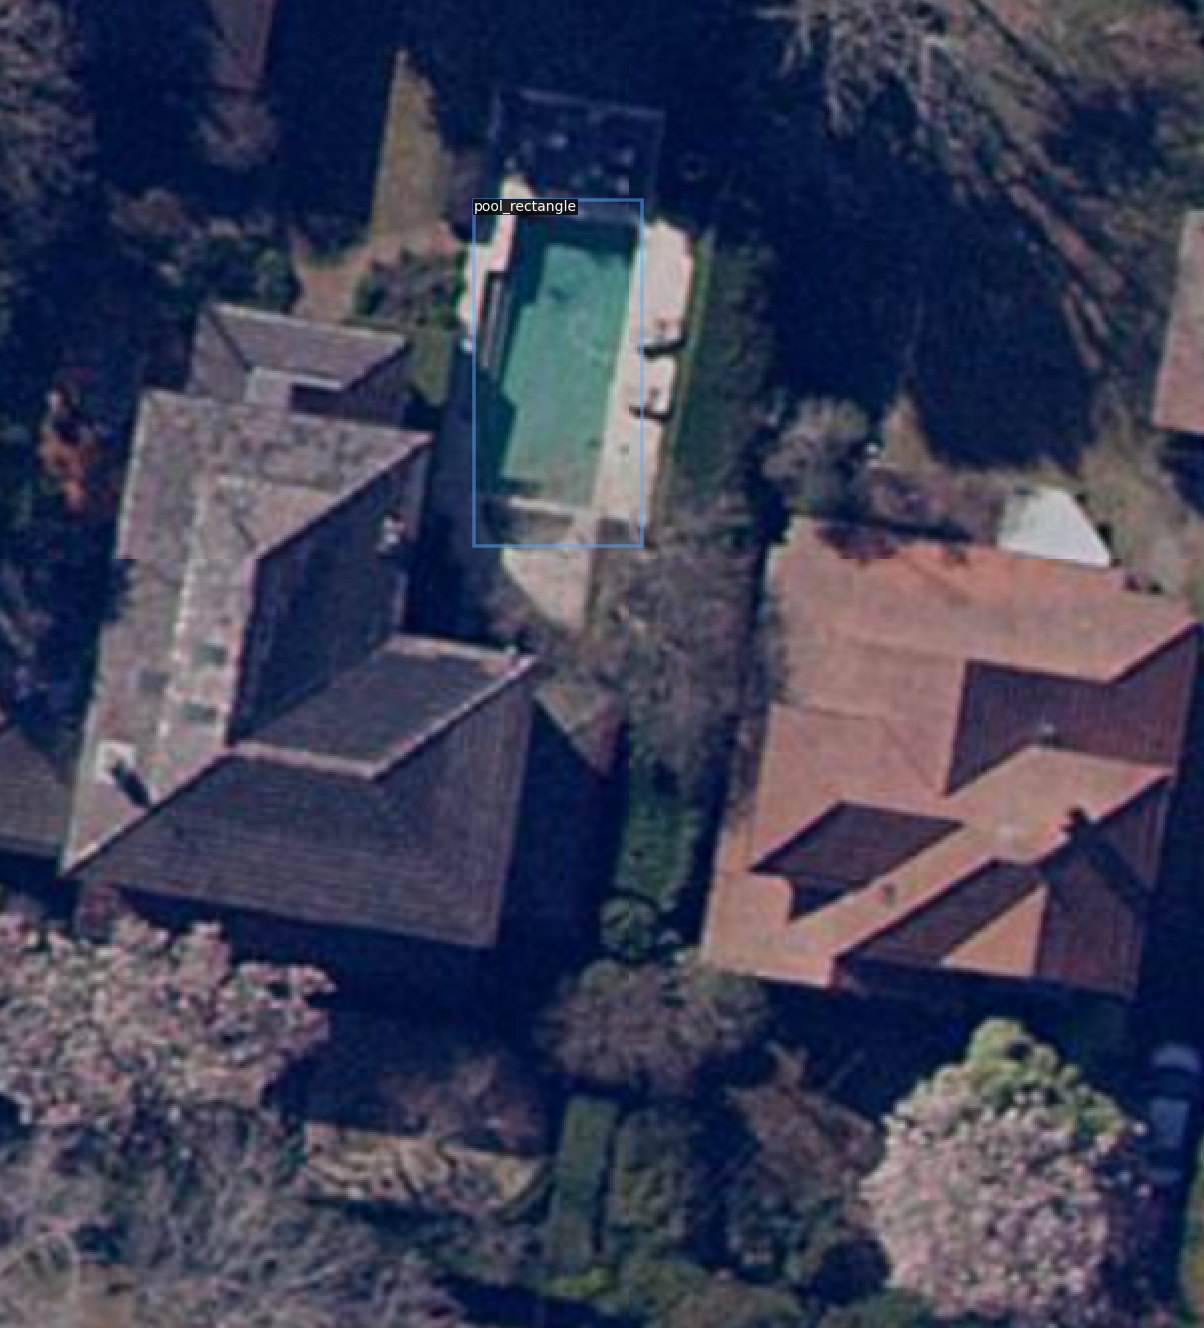

In [ ]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import gc; gc.collect()

11691

In [ ]:
from detectron2.engine import DefaultTrainer

CONFIG = 'COCO-Detection/retinanet_R_50_FPN_1x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG))
cfg.DATASETS.TRAIN = (NAME + '_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CLASSES)  
cfg.MODEL.RETINANET.NUM_CLASSES  = len(CLASSES)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[02/28 07:33:57 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.


[02/28 07:33:58 d2.engine.train_loop]: Starting training from iteration 0
[02/28 07:34:02 d2.utils.events]:  eta: 0:03:36  iter: 19  total_loss: 1.238  loss_cls: 0.872  loss_box_reg: 0.359  time: 0.2091  data_time: 0.0305  lr: 4.9953e-06  max_mem: 14081M
[02/28 07:34:07 d2.utils.events]:  eta: 0:03:30  iter: 39  total_loss: 1.114  loss_cls: 0.855  loss_box_reg: 0.2936  time: 0.2101  data_time: 0.0088  lr: 9.9902e-06  max_mem: 14081M
[02/28 07:34:16 d2.utils.events]:  eta: 0:03:20  iter: 59  total_loss: 1.307  loss_cls: 1.049  loss_box_reg: 0.2904  time: 0.2955  data_time: 0.0105  lr: 1.4985e-05  max_mem: 14081M
[02/28 07:34:26 d2.utils.events]:  eta: 0:03:13  iter: 79  total_loss: 1.272  loss_cls: 0.9525  loss_box_reg: 0.2715  time: 0.3525  data_time: 0.0178  lr: 1.998e-05  max_mem: 14081M
[02/28 07:34:32 d2.utils.events]:  eta: 0:03:04  iter: 99  total_loss: 1.167  loss_cls: 0.9336  loss_box_reg: 0.2694  time: 0.3398  data_time: 0.0118  lr: 2.4975e-05  max_mem: 14081M
[02/28 07:34:35 

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

NameError: ignored

In [ ]:
!wget https://www.nearmap.com/content/dam/nearmap/aerial-imagery/us/industries/service-contractors/pools/2020-pools/high-resolution-aerial-pools-backyards-Chandler-Arizona.jpg -O test.jpg
!wget https://miro.medium.com/max/1400/1*mnGTgsf6iUxYkJpH5mI4UA.png -O test2.png

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for file in glob.glob('*.*g'):
  print(file)
  im = cv2.imread(file)
  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
  v = Visualizer(im[:, :, ::-1],
                  metadata=metadata, 
                  scale=1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  im = out.get_image()[:, :, ::-1]
  # cv2.resize(im, (500, 500))
  cv2_imshow(im)

In [ ]:
outputs["instances"].to('cpu')